# DailyBeer Sales and Buy

In [1]:
import sqlite3
conn_sales = sqlite3.connect("Sales.db")

# 1. DF_Sales, DF_Bsales, DF_CJsales, DF_Bbuy, DF_CJbuy

In [2]:
from pandas import Series, DataFrame
import pandas as pd


sql_cmd_Sales = """
        select year, month, sum(amount) as Sales
        from  sales
        group by month
        order by year, month
"""
DF_Sales = pd.read_sql_query(sql_cmd_Sales, conn_sales)
DF_Sales = DF_Sales.set_index(['year', 'month'])



sql_cmd_Bsales = """
                    select year, month, sum(amount) as Bsales
                    from sales
                    where cat1 = 2 or cat1 = 6
                    group by year, month
"""
DF_Bsales = pd.read_sql_query(sql_cmd_Bsales, conn_sales)
DF_Bsales = DF_Bsales.set_index(['year', 'month'])



sql_cmd_CJsales = """
                    select year, month, sum(amount) as CJsales
                    from sales
                    where cat1 = 3
                    group by year, month
"""
DF_CJsales = pd.read_sql_query(sql_cmd_CJsales, conn_sales)
DF_CJsales = DF_CJsales.set_index(['year', 'month'])


sql_cmd_Bbuy = """
        select year, month, sum(amount) as Bbuy
        from beer
        group by month
        order by year, month
"""
DF_Bbuy = pd.read_sql_query(sql_cmd_Bbuy, conn_sales)
DF_Bbuy = DF_Bbuy.set_index(['year', 'month'])



sql_cmd_CJbuy = """
        select year, month, sum(total) as CJbuy
        from OrderAll
        group by year, month
        order by year, month
"""
DF_CJbuy = pd.read_sql_query(sql_cmd_CJbuy, conn_sales)
DF_CJbuy = DF_CJbuy.set_index(['year', 'month'])


# Sales:CJsales:Bsales 

### pd.concat( [DF_Bsales, DF_CJsales] , axis = 1)

In [3]:
DF_CJB_Sales = pd.concat( [DF_Bsales, DF_CJsales], axis =1)
DF_CJB_Sales['Sales'] = DF_CJB_Sales['Bsales'] + DF_CJB_Sales['CJsales']
DF_CJB_Sales['CJsales_rate'] = DF_CJB_Sales['CJsales'] / DF_CJB_Sales['Sales'] * 100
DF_CJB_Sales['Bsales_rate'] = DF_CJB_Sales['Bsales'] / DF_CJB_Sales['Sales'] * 100
DF_CJB_Sales

Bsales   CJsales     Sales  CJsales_rate  Bsales_rate
year month                                                         
2017 7      34292379  16890571  51182950     33.000386    66.999614
     8      32386200  18277000  50663200     36.075495    63.924505
     9      26439450  13706500  40145950     34.141676    65.858324
     10     21552100  11784200  33336300     35.349454    64.650546
     11     17135500   9869750  27005250     36.547523    63.452477
     12     17748159  10456191  28204350     37.072973    62.927027
2018 1      18861800  12744000  31605800     40.321713    59.678287
     2      16097564   9275636  25373200     36.556824    63.443176

## 1-1 Sales(total) Graph

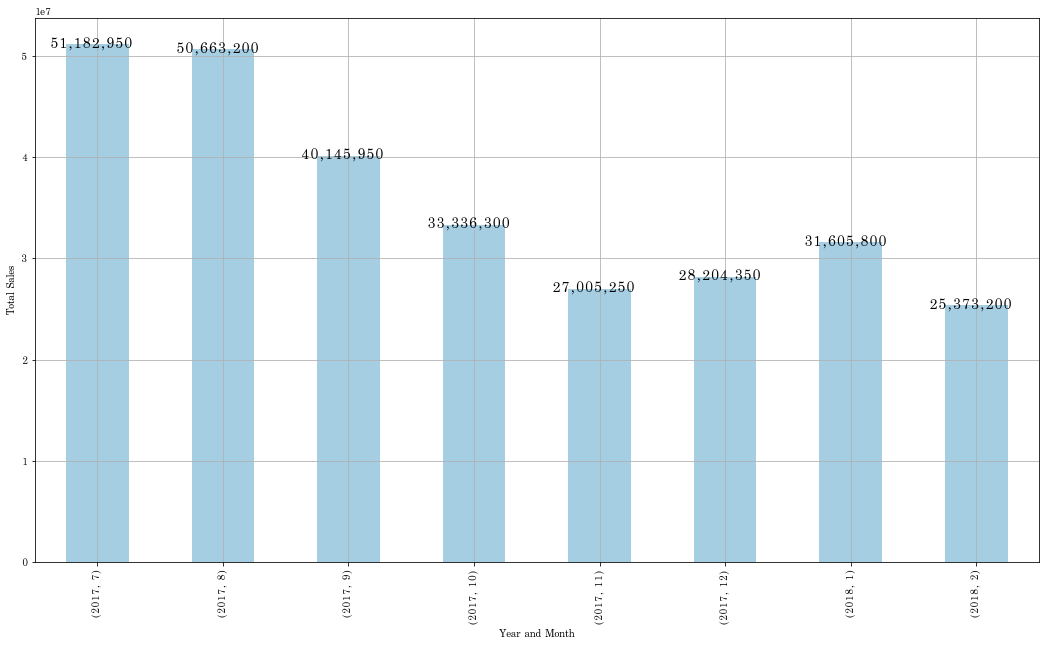

In [14]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


fig = plt.figure()
ax = DF_CJB_Sales['Sales'].plot.bar(stacked=True, figsize=(18,10), grid=True, colormap='Paired')


ax.set_xlabel('Year and Month')
ax.set_ylabel('Total Sales')


labels = []

for i in DF_CJB_Sales.index:
    value_str = "{:<12,}".format(int(DF_CJB_Sales.loc[i]['Sales'])) 
    labels.append(value_str)


# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height-5., label, ha='center', va='center', fontsize=14)

fig  = ax.get_figure()
fig.savefig('1-1-Sales-Total.png')
plt.show()



## 1-2 Sales(CJ:B) Ratio Graph

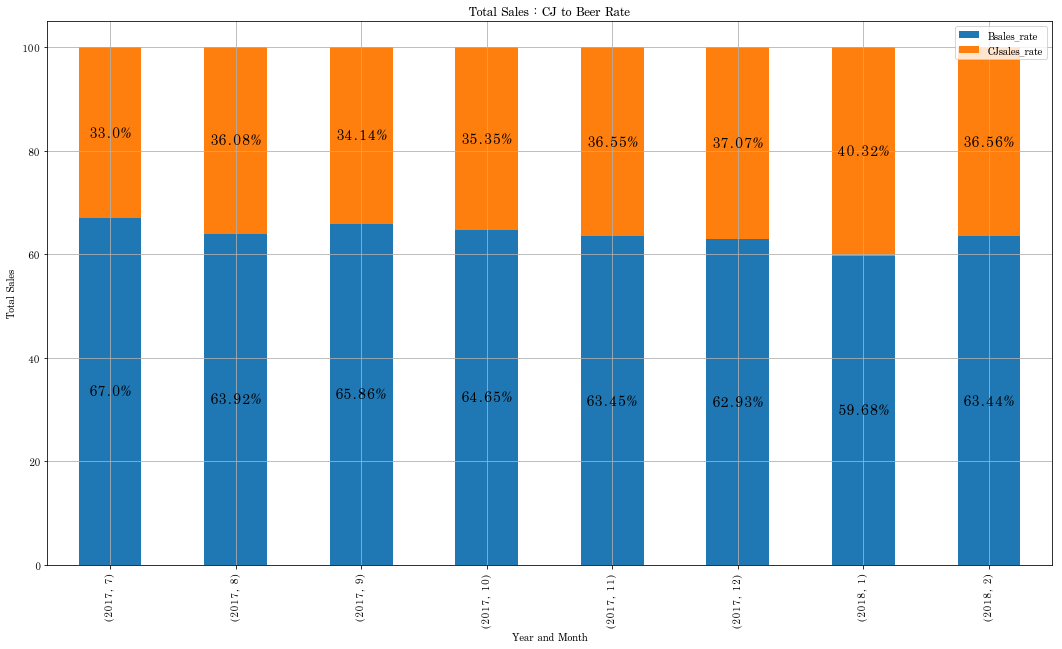

In [15]:


fig = plt.figure()
DF_CJB_Sales_Graph = DF_CJB_Sales[['Bsales_rate', 'CJsales_rate']]
ax = DF_CJB_Sales_Graph.plot.bar(stacked=True, figsize=(18,10), grid=True)

ax.set_title("Total Sales : CJ to Beer Rate")
ax.set_xlabel('Year and Month')
ax.set_ylabel('Total Sales')

pct_str=""
value_str=""
labels = []
for j in DF_CJB_Sales_Graph.columns:
    pct_str=""
    for i in DF_CJB_Sales_Graph.index:
#        value_str = "{:<12,}".format(int(DF_CJB_Sales_Graph.loc[i][j])) 
        
        if j == 'Bsales_rate':
            pct_str = "{0:.4}%".format(DF_CJB_Sales.loc[i]['Bsales_rate'])
        elif j == 'CJsales_rate':
            pct_str = "{0:.4}%".format(DF_CJB_Sales.loc[i]['CJsales_rate'])

        if pct_str != "":
            value_str = value_str + "::" + pct_str
#       label = DF_RCB[i][j] 
#        labels.append(value_str)
        labels.append(pct_str)


# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize=14)

fig  = ax.get_figure()
fig.savefig('1-2-Sales-CJ-B Rate.png')

plt.show()




## 1-3 Sales Analysis Group by Lager/Ale/Food/Chicken

In [6]:
sql_sales_2161 = """
        select year, month, sum(amount) as Lager
        from Sales
        where cat2 = 21 or cat2 = 61
        group by year, month
        
"""
DF_Sannot_2161 = pd.read_sql_query(sql_sales_2161, conn_sales)
DF_Sannot_2161 = DF_Sannot_2161.set_index(['year', 'month'])

sql_sales_2262 = """
        select year, month, sum(amount) as Ale
        from Sales
        where cat2 = 22 or cat2 = 62
        group by year, month
        
"""
DF_Sannot_2262 = pd.read_sql_query(sql_sales_2262, conn_sales)
DF_Sannot_2262 = DF_Sannot_2262.set_index(['year', 'month'])

sql_sales_3031 = """
        select year, month, sum(amount) as CJSell
        from Sales
        where cat2 = 30 or cat2 = 31
        group by year, month
        
"""
DF_Sannot_3031 = pd.read_sql_query(sql_sales_3031, conn_sales)
DF_Sannot_3031 = DF_Sannot_3031.set_index(['year', 'month'])


sql_sales_3567 = """
        select year, month, sum(amount) as Chickens
        from Sales
        where cat2 = 35 or cat2 = 36 or cat2 = 37
        group by year, month
        
"""
DF_Sannot_3567 = pd.read_sql_query(sql_sales_3567, conn_sales)
DF_Sannot_3567 = DF_Sannot_3567.set_index(['year', 'month'])

DF_Sannot = pd.concat([DF_Sannot_2161, DF_Sannot_2262, DF_Sannot_3031, DF_Sannot_3567], axis=1)
DF_Sannot['Total_Sale'] = DF_Sannot['Lager'] + DF_Sannot['Ale'] + DF_Sannot['CJSell'] + DF_Sannot['Chickens']
DF_Sannot['Lager%'] = DF_Sannot['Lager'] / DF_Sannot['Total_Sale'] * 100
DF_Sannot['Ale%'] = DF_Sannot['Ale'] / DF_Sannot['Total_Sale'] * 100
DF_Sannot['CJSell%'] = DF_Sannot['CJSell'] / DF_Sannot['Total_Sale'] * 100
DF_Sannot['Chicken%'] = DF_Sannot['Chickens'] / DF_Sannot['Total_Sale'] * 100

DF_Sannot

Lager       Ale    CJSell  Chickens  Total_Sale     Lager%  \
year month                                                                  
2017 7      12408856  21883523  10054802   6835769    51182950  24.244120   
     8      10982300  21403900  10537500   7739500    50663200  21.677075   
     9      10248900  16190550   8641000   5065500    40145950  25.529101   
     10      8985300  12566800   6661200   5123000    33336300  26.953501   
     11      6865200  10270300   5840250   4029500    27005250  25.421724   
     12      7176604  10571555   6271341   4184850    28204350  25.445025   
2018 1       6875900  11985900   8269000   4475000    31605800  21.755184   
     2       6657538   9440026   5418119   3857517    25373200  26.238464   

                 Ale%    CJSell%   Chicken%  
year month                                   
2017 7      42.755494  19.644827  13.355559  
     8      42.247430  20.799120  15.276374  
     9      40.329224  21.523964  12.617711  
     10     37.697045  19.981822  15.367632  
     11     38.030753  21.626350  14.921173  
     12     37.482002  22.235368  14.837605  
2018 1      37.923103  26.162919  14.158794  
     2      37.204712  21.353708  15.203116

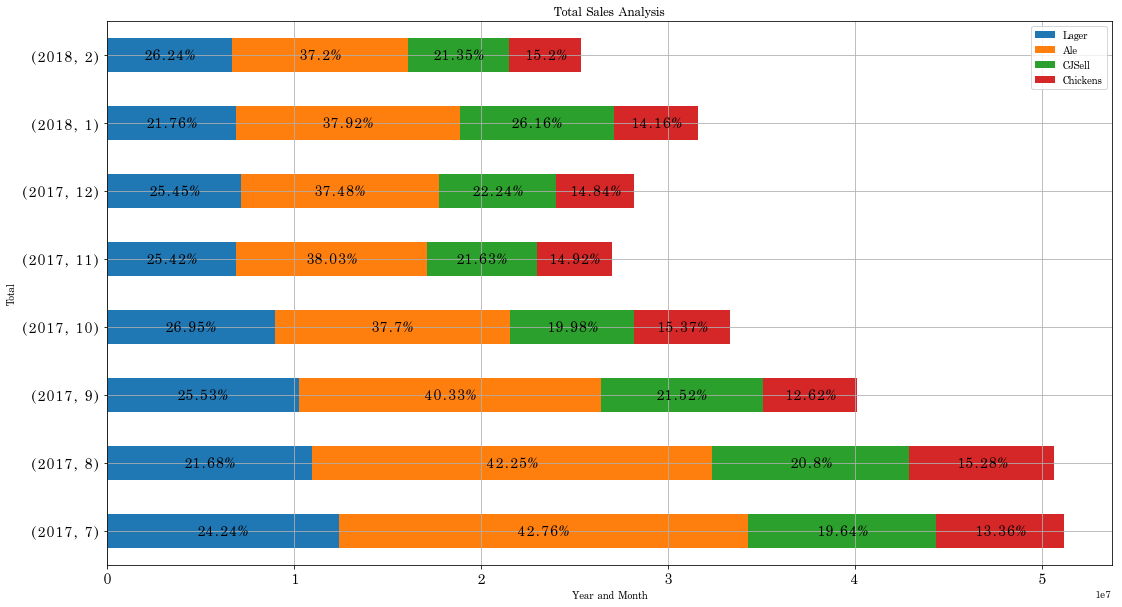

In [16]:

fig = plt.figure()

ax = DF_Sannot[['Lager','Ale','CJSell', 'Chickens']].plot.barh(stacked=True, figsize=(18,10), grid=True, fontsize=14)

ax.set_title('Total Sales Analysis')
ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')


pct_str=""
labels = []
for j in DF_Sannot[['Lager','Ale','CJSell', 'Chickens']].columns:
    pct_str=""
    for i in DF_Sannot.index:
#        value_str = "{:<12,}".format(int(DF_RCB.loc[i][j])) 

        if j == 'Lager':
            pct_str = "{0:.4}%".format(DF_Sannot.loc[i]['Lager%'])
        elif j == 'Ale':
            pct_str = "{0:.4}%".format(DF_Sannot.loc[i]['Ale%'])
        elif j == 'CJSell':
            pct_str = "{0:.4}%".format(DF_Sannot.loc[i]['CJSell%'])
        elif j == 'Chickens':
            pct_str = "{0:.4}%".format(DF_Sannot.loc[i]['Chicken%'])

#        if pct_str != "":
#            value_str = value_str + "::" + pct_str
        value_str = pct_str
        labels.append(value_str)

# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize=14)

fig  = ax.get_figure()
fig.savefig('1-3-Total Sales Analysis.png')

plt.show()

## 1-4-Beer Sales(sum(amount)) Analysis : Group by a kind of Ale

In [17]:
sql_beer_analysis = """
                select year, month, pname, amount
                from sales
                where cat1 = 2
"""

DF_Beer_Sale = pd.read_sql_query(sql_beer_analysis, conn_sales)
DF_Beer_Sale = DF_Beer_Sale.set_index(['year', 'month'])
# DF_Beer_Sale

In [18]:
import numpy as np
DF_Bsale_pivot = pd.pivot_table(DF_Beer_Sale, values='amount', index=['year', 'month'], columns=['pname'], aggfunc=np.sum)
DF_Bsale_pivot

pname        강남페일에일    걸작IPA    놀라운에일  레드락IPA     레드락라거   모카스타우트    샘플러5종  \
year month                                                                  
2017 7      3133000  3244423  2112681  637000  12389956  2516423  3997336   
     8      3388450  2454200  1942200  598000  10968800  2571800  4087500   
     9      2801500  1428000  2028000  468000  10230000  1799000  3540000   
     10     1869000   889000  1885000  403000   8966400  1596000  2340000   
     11     1820000   938000  1462500  240500   6789600  1274000  1695000   
     12     1566500   745542  1511288  273000   7102624  1685950  1914839   
2018 1      1943500  1218000  2000700  266500   6819200  1596000  1695000   
     2      1487828   644000  1754221  201500   6579238  1480244  1304524   

pname          생활밀착     설레임  슬로우IPA    일상탈출  하와이안골든에일  
year month                                             
2017 7      5554360       0  560000       0         0  
     8      5476250       0  574000       0         0  
     9      3643250       0  434000       0         0  
     10     2931500       0  259000  252000         0  
     11     2073500       0       0  623000         0  
     12     1969500  203000       0  471491         0  
2018 1      1760000  462000       0  712000         0  
     2      1358276  497000       0  524533         0

In [18]:
matplotlib.matplotlib_fname()

u'/Users/kwool/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc'

In [20]:
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()

[]

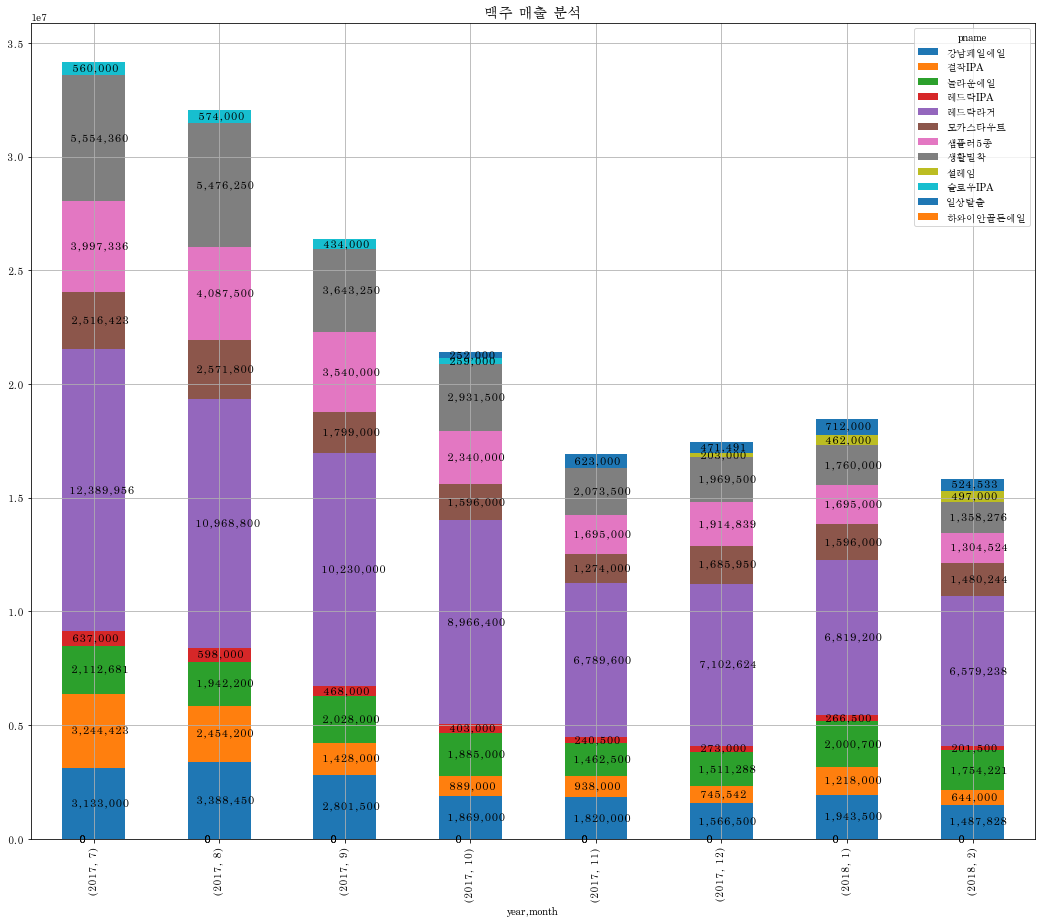

In [19]:

ax = DF_Bsale_pivot.plot.bar(stacked=True, grid=True, figsize=(18,15))

plt.rcParams["font.family"] = 'AppleMyungjo'
plt.rcParams['font.size'] = 12
plt.title(u'맥주 매출 분석')


pct_str=""
labels = []
for j in DF_Bsale_pivot.columns:
    for i in DF_Bsale_pivot.index:
        value_str = "{:<12,}".format(int(DF_Bsale_pivot.loc[i][j])) 
        labels.append(value_str)

patches = ax.patches

for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2.+0.1, y + height/2., label, ha='center', va='center', fontsize=11)
        
fig  = ax.get_figure()
fig.savefig('1-4-Beer Sales Analysis.png')

plt.show()

## 1-5-Beer Sales(%) Analysis : Group By a Kind of Ale

In [20]:
DF_Bsale_pivot_pct = DF_Bsale_pivot
for i in DF_Bsale_pivot.index:
    DF_Bsale_pivot_pct.loc[i] = DF_Bsale_pivot.loc[i] / DF_Bsale_pivot.loc[i].sum() * 100
DF_Bsale_pivot_pct

pname          강남페일에일     걸작IPA      놀라운에일    레드락IPA      레드락라거    모카스타우트  \
year month                                                                  
2017 7       9.175527  9.501848   6.187348  1.865564  36.286106  7.369775   
     8      10.568694  7.654735   6.057789  1.865183  34.212069  8.021534   
     9      10.623110  5.414885   7.690047  1.774626  38.791510  6.821694   
     10      8.737360  4.155973   8.812158  1.883979  41.916890  7.461117   
     11     10.758981  5.545013   8.645610  1.421723  40.136911  7.531287   
     12      8.980302  4.273982   8.663787  1.565032  40.717337  9.665075   
2018 1      10.520817  6.593442  10.830460  1.442654  36.914615  8.639683   
     2       9.397977  4.067874  11.080669  1.272790  41.558251  9.350072   

pname           샘플러5종       생활밀착       설레임    슬로우IPA      일상탈출  하와이안골든에일  
year month                                                                
2017 7      11.706883  16.266894  0.000000  1.640056  0.000000       0.0  
     8      12.749055  17.080615  0.000000  1.790326  0.000000       0.0  
     9      13.423455  13.814972  0.000000  1.645700  0.000000       0.0  
     10     10.939231  13.704426  0.000000  1.210795  1.178071       0.0  
     11     10.020040  12.257553  0.000000  0.000000  3.682882       0.0  
     12     10.977231  11.290587  1.163742  0.000000  2.702925       0.0  
2018 1       9.175603   9.527470  2.500961  0.000000  3.854295       0.0  
     2       8.240124   8.579652  3.139338  0.000000  3.313252       0.0

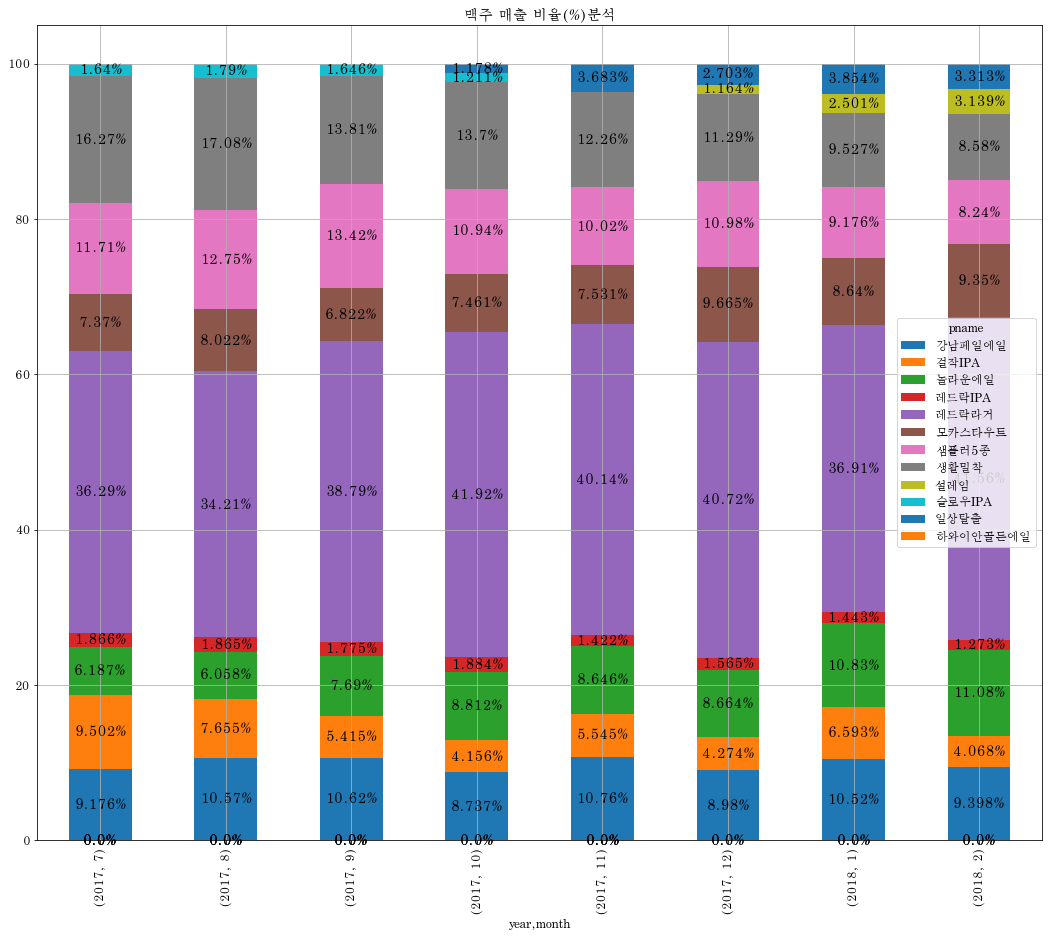

In [21]:

ax = DF_Bsale_pivot_pct.plot.bar(stacked=True, grid=True, figsize=(18,15))

plt.rcParams["font.family"] = 'AppleMyungjo'
plt.rcParams['font.size'] = 12
plt.title(u'맥주 매출 비율(%)분석')


pct_str=""
labels = []
for j in DF_Bsale_pivot_pct.columns:
    for i in DF_Bsale_pivot_pct.index:
        value_str = "{0:.4}%".format(DF_Bsale_pivot_pct.loc[i][j]) 
        labels.append(value_str)

patches = ax.patches

for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize=14)
        
fig  = ax.get_figure()
fig.savefig('1-5-Beer Sales Percentage Analysis.png')

plt.show()

## 1-6-Food Sales (sum(amount))  Analysis

In [54]:
sql_food_analysis = """
                select year, month, pname, amount
                from sales
                where cat1 = 3
"""

DF_Food_Sale_Table = pd.read_sql_query(sql_food_analysis, conn_sales)
#DF_Food_Sale_Table = DF_Food_Sale_Table.set_index(['year', 'month'])
#DF_Food_Sale_Table

In [55]:
DF_Food_Sale = pd.pivot_table(DF_Food_Sale_Table, values='amount', index=['year','month'], columns='pname', aggfunc=sum)
DF_Food_Sale

pname          골빔면  그린라이트사라다      나초칩  맥앤치즈샐러드   백화점육포     버팔로윙  봉다리복만두  \
year month                                                                
2017 7      981000    689000  1160000   728000  671000   136500       0   
     8      963000   1014000  1152000   494000  660000  1014000       0   
     9      639000    416000   904000   416000  495000   832500       0   
     10     448200    325000   648000   221000  451000   780000       0   
     11     294750    416000   616000   442000  440000   660000       0   
     12     279000    442000   680000   364000  495000   594750       0   
2018 1      306000    338000   776000   273000  473000   765000  186000   
     2      315000    299000   776000   247000  275000   645000  180000   

pname          뻘건감자     사이다  소시지와친구들     스팸튀김    앵그리버드  앵그리버드RED  \
year month                                                         
2017 7      1127194  309000  1033358   387000  4344269         0   
     8      1120000  339000  1235000   567000  4456000         0   
     9      1029000  237000  1105000   450000  2208000         0   
     10      721000  213000   624000   342000  1706000    979000   
     11      574000  140250   598000   270000  1280000    544000   
     12      680091  273000   611000   243000  1185600    544000   
2018 1       709000  162000   559000  2322000  1384000    459000   
     2       460000  168000   546000   198000  1353557    372000   

pname       앵그리버드RED(반반)  촉촉오징어땅콩      콜라   크리스피텐더     허연감자  
year month                                                   
2017 7                 0  1440000  269250  2355000  1260000  
     8                 0  1370000  225000  2269500  1398500  
     9                 0  1440000  180000  2025000  1330000  
     10           221000  1100000  168000  1437000  1400000  
     11           335750   917000  131250  1209750  1001000  
     12           386000  1000000  182250  1474500  1022000  
2018 1            442000   910000  144000  1425000  1111000  
     2            286960   980000  138000  1200000   836119

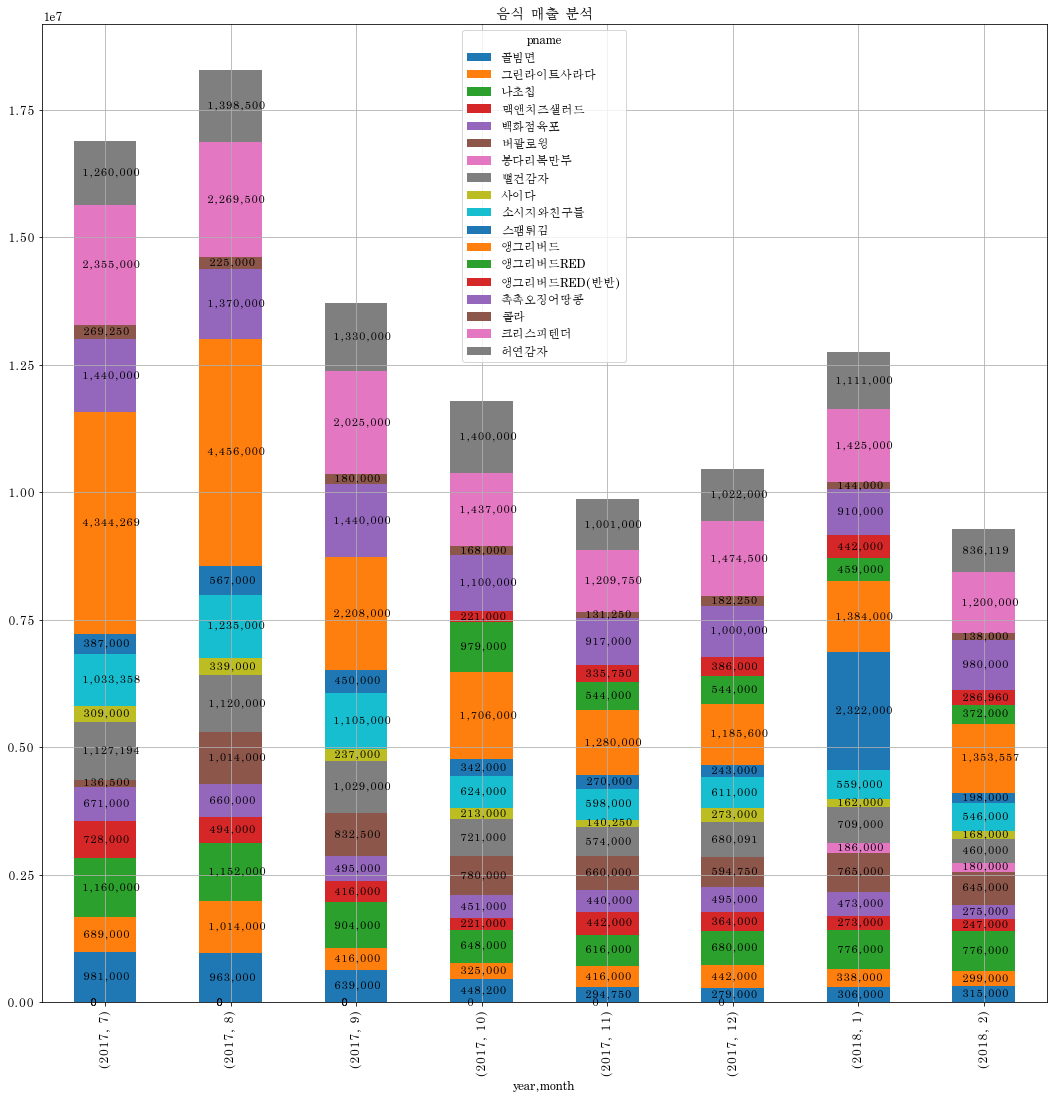

In [56]:

ax = DF_Food_Sale.plot.bar(stacked=True, grid=True, figsize=(18,18))

#plt.rcParams["font.family"] = 'AppleMyungjo'
#plt.rcParams['font.size'] = 12
plt.title(u'음식 매출 분석')


labels = []
for j in DF_Food_Sale.columns:
    for i in DF_Food_Sale.index:
        value_str = "{:<12,}".format(int(DF_Food_Sale.loc[i][j])) 
        labels.append(value_str)

patches = ax.patches

for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2.+0.1, y + height/2., label, ha='center', va='center', fontsize=11)
        
fig  = ax.get_figure()
fig.savefig('1-6-Food Sales Analysis.png')

plt.show()

## 1-7-Food Sales(%) Analysis 

In [57]:
DF_Food_Sale_pct = DF_Food_Sale
for i in DF_Food_Sale.index:
    DF_Food_Sale_pct.loc[i] = DF_Food_Sale.loc[i] / DF_Food_Sale.loc[i].sum() * 100
DF_Food_Sale_pct

pname            골빔면  그린라이트사라다       나초칩   맥앤치즈샐러드     백화점육포      버팔로윙  \
year month                                                               
2017 7      5.807974  4.079199  6.867737  4.310097  3.972631  0.808143   
     8      5.268917  5.547956  6.303004  2.702851  3.611096  5.547956   
     9      4.662022  3.035056  6.595411  3.035056  3.611425  6.073761   
     10     3.803398  2.757930  5.498888  1.875392  3.827158  6.619032   
     11     2.986398  4.214899  6.241293  4.478330  4.458066  6.687099   
     12     2.668276  4.227161  6.503324  3.481191  4.734037  5.688018   
2018 1      2.401130  2.652228  6.089140  2.142185  3.711551  6.002825   
     2      3.395994  3.223499  8.366003  2.662890  2.964756  6.953701   

pname         봉다리복만두      뻘건감자       사이다   소시지와친구들       스팸튀김      앵그리버드  \
year month                                                                 
2017 7      0.000000  6.673510  1.829423  6.117958   2.291219  25.720084   
     8      0.000000  6.127920  1.854790  6.757126   3.102260  24.380369   
     9      0.000000  7.507387  1.729107  8.061868   3.283114  16.109145   
     10     0.000000  6.118362  1.807505  5.295226   2.902191  14.477012   
     11     0.000000  5.815750  1.421009  6.058917   2.735632  12.968920   
     12     0.000000  6.504195  2.610893  5.843428   2.323982  11.338737   
2018 1      1.459510  5.563402  1.271186  4.386378  18.220339  10.860013   
     2      1.940568  4.959229  1.811197  5.886389   2.134625  14.592606   

pname       앵그리버드RED  앵그리버드RED(반반)    촉촉오징어땅콩        콜라     크리스피텐더       허연감자  
year month                                                                     
2017 7      0.000000      0.000000   8.525467  1.594085  13.942690   7.459783  
     8      0.000000      0.000000   7.495760  1.231055  12.417246   7.651693  
     9      0.000000      0.000000  10.505964  1.313246  14.774012   9.703425  
     10     8.307734      1.875392   9.334533  1.425638  12.194294  11.880314  
     11     5.511791      3.401809   9.291015  1.329821  12.257149  10.142101  
     12     5.202659      3.691593   9.563712  1.742987  14.101693   9.774114  
2018 1      3.601695      3.468299   7.140615  1.129944  11.181733   8.717828  
     2      4.010507      3.093696  10.565313  1.487769  12.937118   9.014142

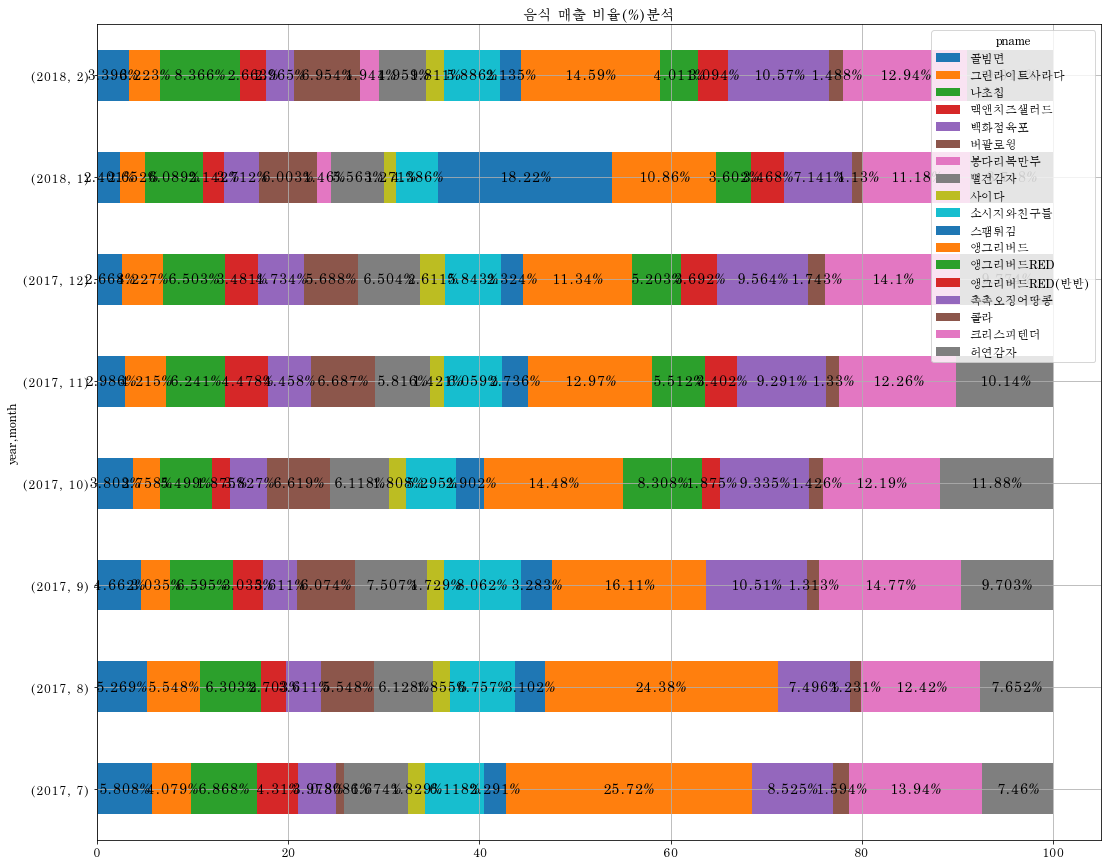

In [45]:

ax = DF_Food_Sale_pct.plot.barh(stacked=True, grid=True, figsize=(18,15))

#plt.rcParams["font.family"] = 'AppleMyungjo'
#plt.rcParams['font.size'] = 12
plt.title(u'음식 매출 비율(%)분석')


pct_str=""
labels = []
for j in DF_Food_Sale_pct.columns:
    for i in DF_Food_Sale_pct.index:
        value_str = "{0:.4}%".format(DF_Food_Sale_pct.loc[i][j]) 
        labels.append(value_str)

patches = ax.patches

for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize=14)
        
fig  = ax.get_figure()
fig.savefig('1-7-Food Sales Percentage Analysis.png')

plt.show()

# 2. Sales:CJbuy:Bbuy

## pd.concat( [DF_Sales, DF_CJbuy,  DF_Bbuy] )  and Calcuate the CJB Rate 

In [59]:

DF_M = pd.concat([DF_Sales, DF_CJbuy, DF_Bbuy], axis=1)
DF_M.loc[DF_M['Bbuy'].isnull(), 'Bbuy'] = 0

DF_M['R'] = DF_M['Sales'] - ( DF_M['CJbuy'] + DF_M['Bbuy'])
DF_M['CJ+Beer_Rate'] = ((DF_M['CJbuy'] + DF_M['Bbuy']) / DF_M['Sales'] * 100)
DF_M['CJ_Rate'] = (DF_M['CJbuy'] / DF_M['Sales']) * 100
DF_M['Beer_Rate'] = (DF_M['Bbuy'] / DF_M['Sales']) * 100
DF_M['R_Rate'] = (DF_M['R']/DF_M['Sales']) * 100
DF_M

Sales    CJbuy       Bbuy           R  CJ+Beer_Rate    CJ_Rate  \
year month                                                                      
2017 7      51182950  8474601        0.0  42708349.0     16.557469  16.557469   
     8      50663200  7594394        0.0  43068806.0     14.989961  14.989961   
     9      40145950  6673702  8510300.0  24961948.0     37.822002  16.623600   
     10     33336300  4974996  7362700.0  20998604.0     37.009794  14.923660   
     11     27005250  4325622  3511400.0  19168228.0     29.020365  16.017708   
     12     28204350  4400016  6820800.0  16983534.0     39.783991  15.600487   
2018 1      31605800  2959125  5753900.0  22892775.0     27.567804   9.362601   
     2      25373200  3821956  5687000.0  15864244.0     37.476377  15.062964   

            Beer_Rate     R_Rate  
year month                        
2017 7       0.000000  83.442531  
     8       0.000000  85.010039  
     9      21.198402  62.177998  
     10     22.086134  62.990206  
     11     13.002657  70.979635  
     12     24.183504  60.216009  
2018 1      18.205203  72.432196  
     2      22.413413  62.523623

## 2-1-Sales:CJbuy:Bbuy Graph

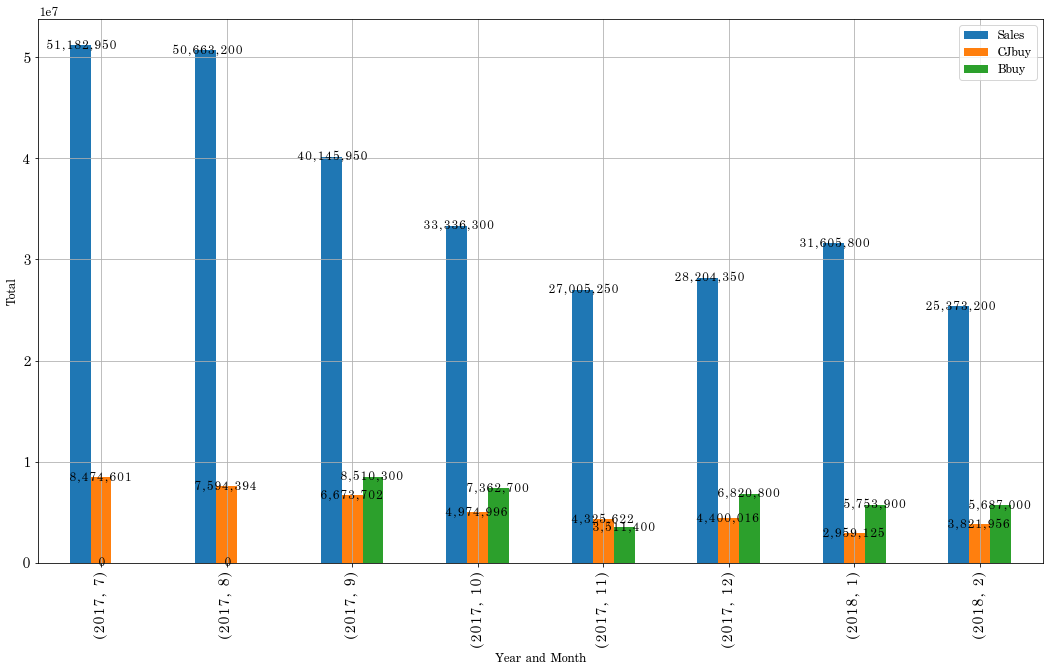

In [60]:

fig = plt.figure()
DF_RCB = DF_M[['Sales', 'CJbuy', 'Bbuy']]
ax = DF_RCB.plot.bar(stacked=False, figsize=(18,10), grid=True, fontsize=14)

ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

pct_str=""
labels = []
for j in DF_RCB.columns:
    pct_str=""
    for i in DF_RCB.index:
        value_str = "{:<12,}".format(int(DF_RCB.loc[i][j])) 
        labels.append(value_str)

# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2. + 0.05, y + height, label, ha='center', va='center', fontsize=12)

fig  = ax.get_figure()
fig.savefig('2-1-Sales-CJBbuy total.png')
plt.show()

## 2-2-Sales:CJbuy:Bbuy Rate

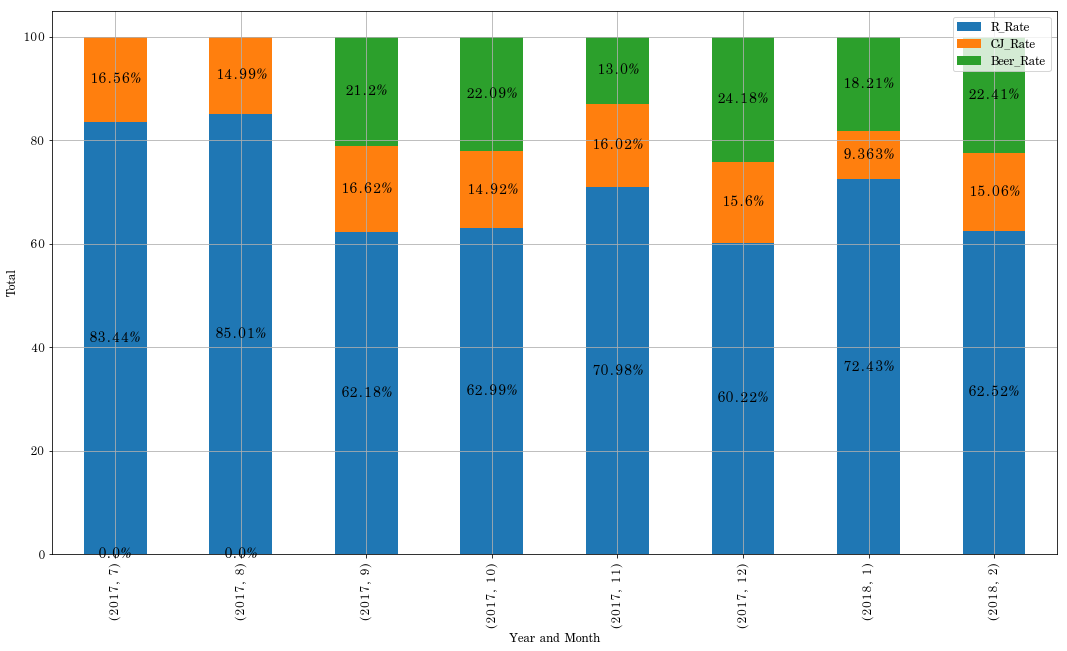

In [61]:

fig = plt.figure()
DF_RCB = DF_M[['R_Rate', 'CJ_Rate', 'Beer_Rate']]
ax = DF_RCB.plot.bar(stacked=True, figsize=(18,10), grid=True)

ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

pct_str=""
labels = []
for j in DF_RCB.columns:
    pct_str=""
    for i in DF_RCB.index:
#        value_str = "{:<12,}".format(int(DF_RCB.loc[i][j])) 

        if j == 'CJ_Rate':
            pct_str = "{0:.4}%".format(DF_M.loc[i]['CJ_Rate'])
        elif j == 'Beer_Rate':
            pct_str = "{0:.4}%".format(DF_M.loc[i]['Beer_Rate'])
        elif j == 'R_Rate':
            pct_str = "{0:.4}%".format(DF_M.loc[i]['R_Rate'])

#        if pct_str != "":
#            value_str = value_str + "::" + pct_str
        value_str = pct_str
        labels.append(value_str)

# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize=14)

fig  = ax.get_figure()
fig.savefig('2-2-Sales-CJBbuy rate.png')
plt.show()


## 2-3-Beer Sell:Buy Rate

In [62]:

DF_Bmerge = pd.concat([DF_Bsales, DF_Bbuy], axis = 1) 
DF_Bmerge.loc[DF_Bmerge['Bbuy'].isnull(), 'Bbuy'] = 0

DF_Bmerge['R'] = DF_Bmerge['Bsales'] - DF_Bmerge['Bbuy']
DF_Bmerge['brate'] = DF_Bmerge['Bbuy'] / DF_Bmerge['Bsales'] * 100
DF_Bmerge['prate'] = 100- (DF_Bmerge['Bbuy'] / DF_Bmerge['Bsales'] * 100)

DF_Bmerge



Bsales       Bbuy           R      brate       prate
year month                                                        
2017 7      34292379        0.0  34292379.0   0.000000  100.000000
     8      32386200        0.0  32386200.0   0.000000  100.000000
     9      26439450  8510300.0  17929150.0  32.187886   67.812114
     10     21552100  7362700.0  14189400.0  34.162332   65.837668
     11     17135500  3511400.0  13624100.0  20.491961   79.508039
     12     17748159  6820800.0  10927359.0  38.431028   61.568972
2018 1      18861800  5753900.0  13107900.0  30.505572   69.494428
     2      16097564  5687000.0  10410564.0  35.328327   64.671673

### Beer Sell:Buy Graph 

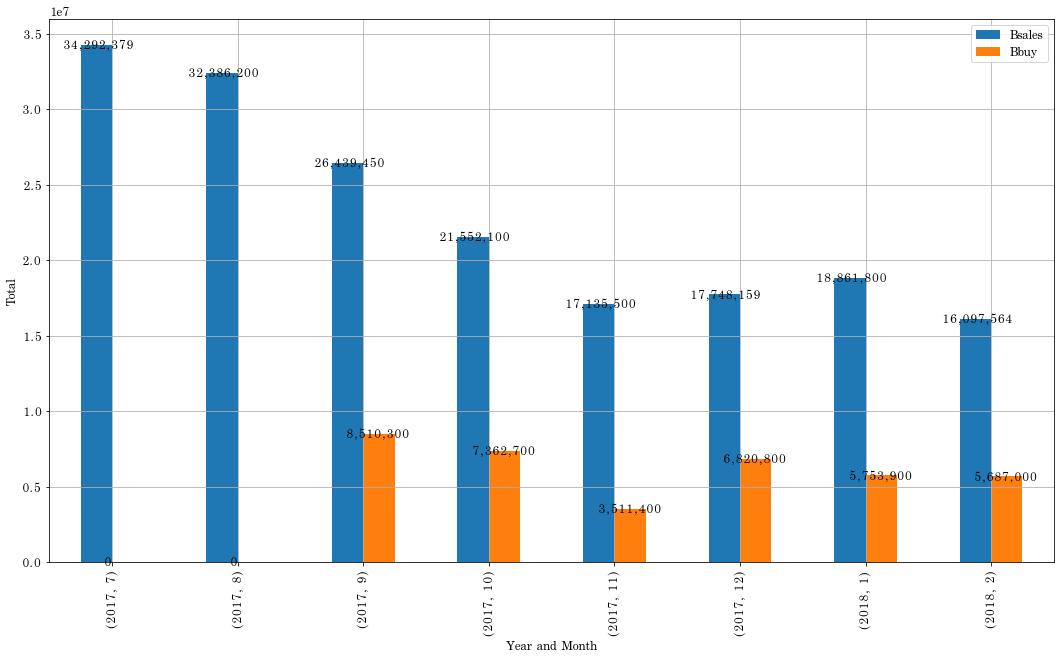

In [63]:

plt.figure()
DF_BMG = DF_Bmerge[['Bsales', 'Bbuy']]
ax = DF_BMG.plot.bar(stacked=False, figsize=(18,10), grid=True)

ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

pct_str=""
labels = []
for j in DF_BMG.columns:
    pct_str=""
    for i in DF_BMG.index:
        value_str = "{:<12,}".format(int(DF_BMG.loc[i][j])) 
        labels.append(value_str)

# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2.+0.05, y + height + 1, label, ha='center', va='center', fontsize=12)


fig = ax.get_figure()
fig.savefig('2-3-Beer Sale-Buy.png')
plt.show()

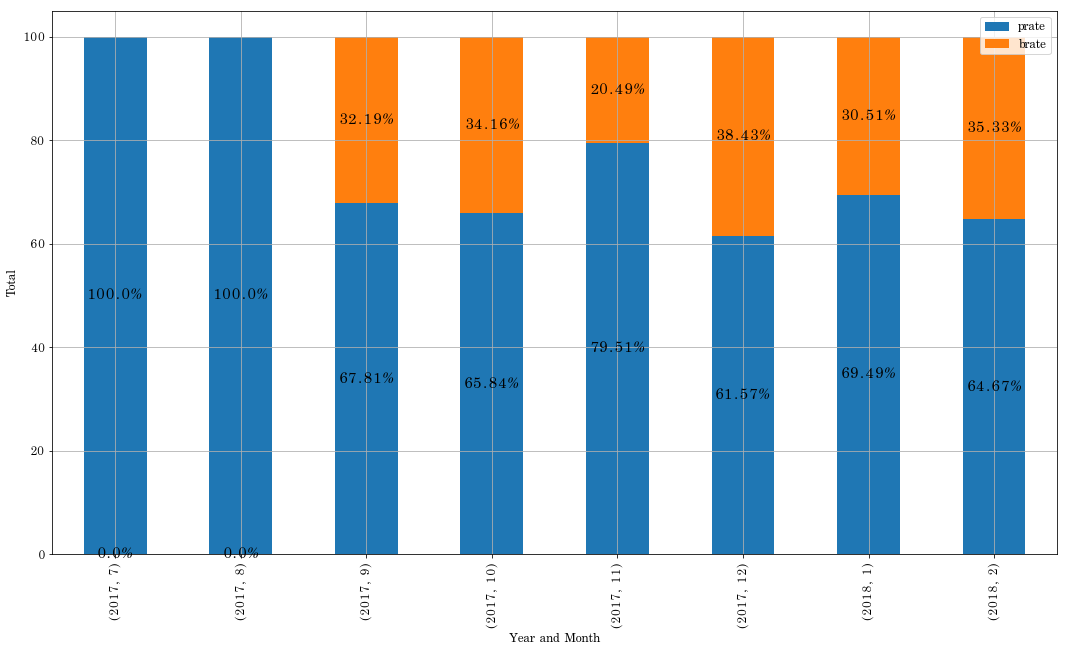

In [64]:

plt.figure()
DF_BMG = DF_Bmerge[['prate', 'brate']]
ax = DF_BMG.plot.bar(stacked=True, figsize=(18,10), grid=True)

ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

pct_str=""
labels = []
for j in DF_BMG.columns:
    pct_str=""
    for i in DF_BMG.index:        
        if j == 'prate':
            pct_str = "{0:.4}%".format(DF_Bmerge.loc[i]['prate'])
        elif j == 'brate':
            pct_str = "{0:.4}%".format(DF_Bmerge.loc[i]['brate'])
       
        value_str = pct_str
        labels.append(value_str)

# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize=15)


fig = ax.get_figure()
fig.savefig('2-4-Beer Sale-Buy Rate.png')
plt.show()

##  2-5-CJ Buy:Sell Rate

In [65]:

DF_CJmerge = pd.concat([DF_CJsales, DF_CJbuy], axis = 1) 

#DF_CJmerge.loc[DF_Bmerge['bbuy'].isnull(), 'bbuy'] = 0

DF_CJmerge['R'] = DF_CJmerge['CJsales'] - DF_CJmerge['CJbuy']
DF_CJmerge['cjrate'] = DF_CJmerge['CJbuy'] / DF_CJmerge['CJsales'] * 100
DF_CJmerge['prate'] = 100- (DF_CJmerge['CJbuy'] / DF_CJmerge['CJsales'] * 100)

DF_CJmerge




CJsales    CJbuy         R     cjrate      prate
year month                                                   
2017 7      16890571  8474601   8415970  50.173561  49.826439
     8      18277000  7594394  10682606  41.551644  58.448356
     9      13706500  6673702   7032798  48.690052  51.309948
     10     11784200  4974996   6809204  42.217512  57.782488
     11      9869750  4325622   5544128  43.827068  56.172932
     12     10456191  4400016   6056175  42.080486  57.919514
2018 1      12744000  2959125   9784875  23.219750  76.780250
     2       9275636  3821956   5453680  41.204247  58.795753

###  CJ Sell:Buy Graph

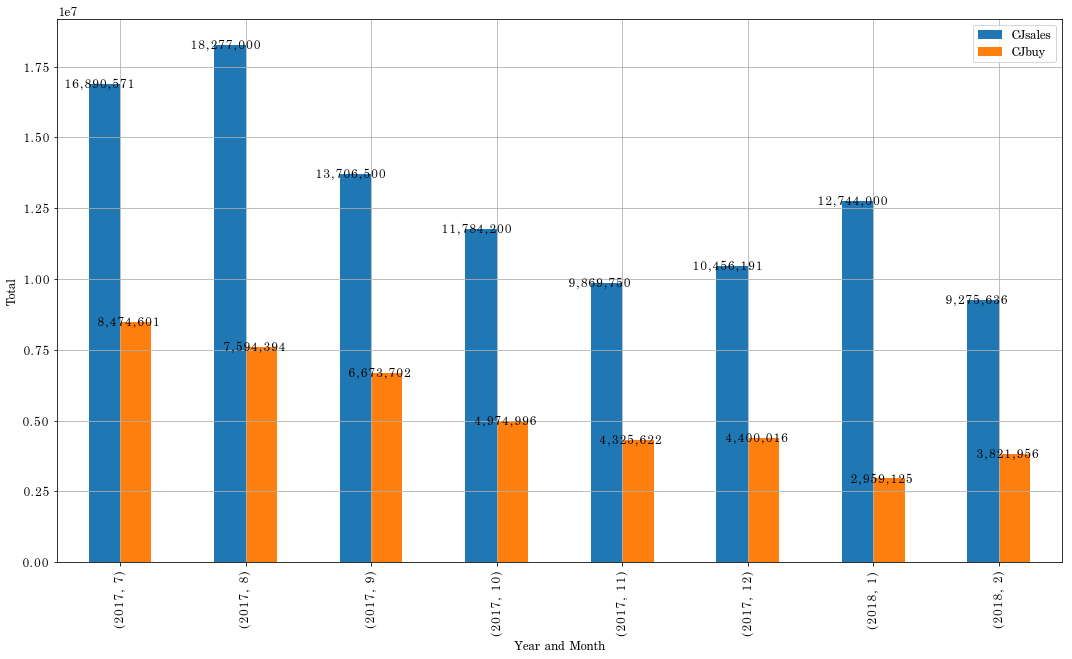

In [66]:

plt.figure()
DF_CJMG = DF_CJmerge[['CJsales', 'CJbuy']]
ax = DF_CJMG.plot.bar(stacked=False, figsize=(18,10), grid=True)

ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

pct_str=""
labels = []
for j in DF_CJMG.columns:
    pct_str=""
    for i in DF_CJMG.index:
        value_str = "{:<12,}".format(int(DF_CJMG.loc[i][j])) 
        labels.append(value_str)

# print labels

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height+5, label, ha='center', va='center', fontsize=12)


fig = ax.get_figure()
fig.savefig('2-5-CJ Sell-Buy Rate.png')
plt.show()

## 2-6-CJ Sell:Buy Rate

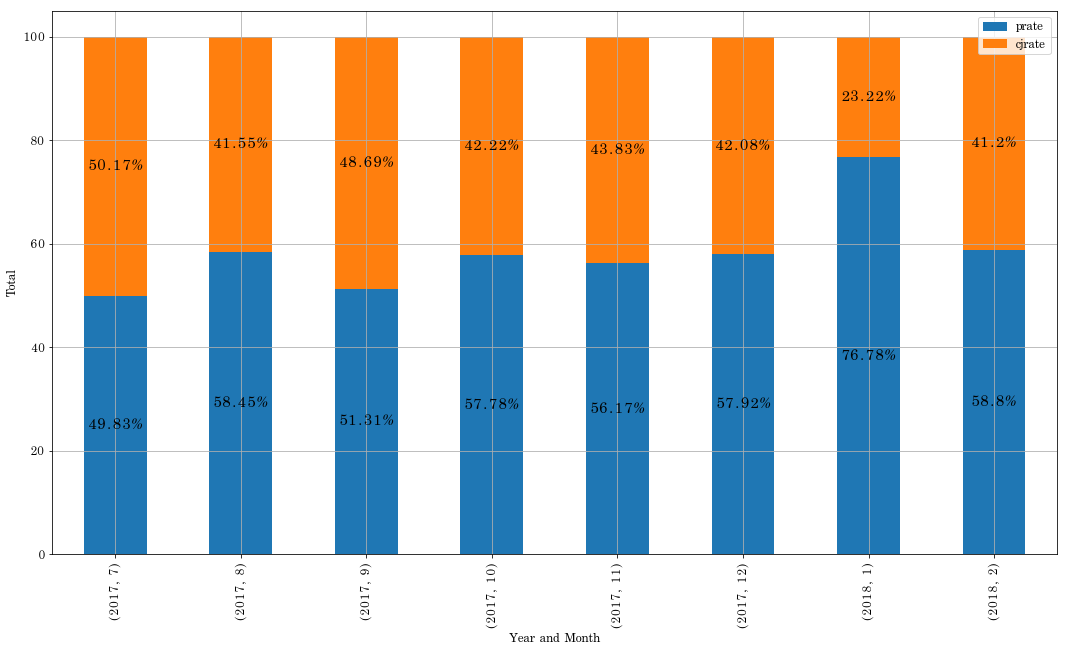

In [67]:
###### plt.figure()
DF_CJMG = DF_CJmerge[['prate', 'cjrate']]
ax = DF_CJMG.plot.bar(stacked=True, figsize=(18,10), grid=True)

ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

pct_str=""
labels = []
for j in DF_CJMG.columns:
    pct_str=""
    for i in DF_CJMG.index:
        value_str = "{0:.4}%".format(DF_CJMG.loc[i][j]) 
        labels.append(value_str)

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize = 15)


fig = ax.get_figure()
fig.savefig('2-6-CJ Sell-Buy Rate.png')
plt.show()
    

## 2-7-Lager

In [68]:
sql_lager_sales = """
                select year, month, sum(amount) as Lsales
                from sales
                where cat2 = 21 or cat2 = 61
                group by year, month
"""
DF_Lsales = pd.read_sql_query(sql_lager_sales, conn_sales)
DF_Lsales = DF_Lsales.set_index(['year', 'month'])

sql_lager_buy = """
                select year, month, sum(amount) as Lbuy
                from beer
                where cat = 21
                group by year, month
"""
DF_Lbuy = pd.read_sql_query(sql_lager_buy, conn_sales)
DF_Lbuy = DF_Lbuy.set_index(['year', 'month'])

DF_LM = pd.concat([DF_Lsales, DF_Lbuy], axis=1)
DF_LM.loc[DF_LM['Lbuy'].isnull(), 'Lbuy']= 0
DF_LM['Lbuy_rate'] = DF_LM['Lbuy'] / DF_LM['Lsales'] * 100
DF_LM['R_rate'] = 100 - DF_LM['Lbuy_rate']
DF_LM

Lsales       Lbuy  Lbuy_rate      R_rate
year month                                            
2017 7      12408856        0.0   0.000000  100.000000
     8      10982300        0.0   0.000000  100.000000
     9      10248900  3078500.0  30.037370   69.962630
     10      8985300  4451700.0  49.544256   50.455744
     11      6865200  1642400.0  23.923556   76.076444
     12      7176604  4440800.0  61.878850   38.121150
2018 1       6875900  3814900.0  55.482191   44.517809
     2       6657538  3544500.0  53.240402   46.759598

### Lager Sell:Buy Graph

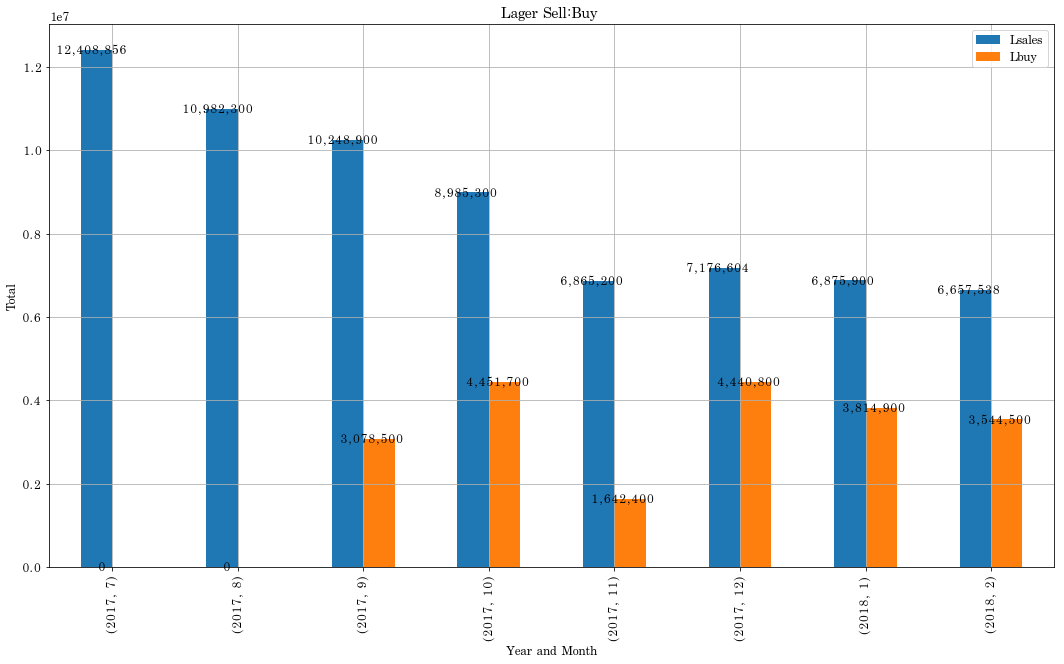

In [69]:

#plt.figure()

ax = DF_LM[['Lsales', 'Lbuy']].plot.bar(stacked=False, figsize=(18,10), grid=True)

ax.set_title('Lager Sell:Buy ')
ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

labels = []
for j in DF_LM[['Lsales', 'Lbuy']].columns:
    pct_str=""
    for i in DF_LM.index:
        value_str = "{:<12,}".format(int(DF_LM.loc[i][j])) 
        
        labels.append(value_str)

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height+0.5, label, ha='center', va='center', fontsize = 12)


fig = ax.get_figure()
fig.savefig('2-7-Lager Sell-Buy.png')
plt.show()


## 2-8-Lager Sell:Buy Rate

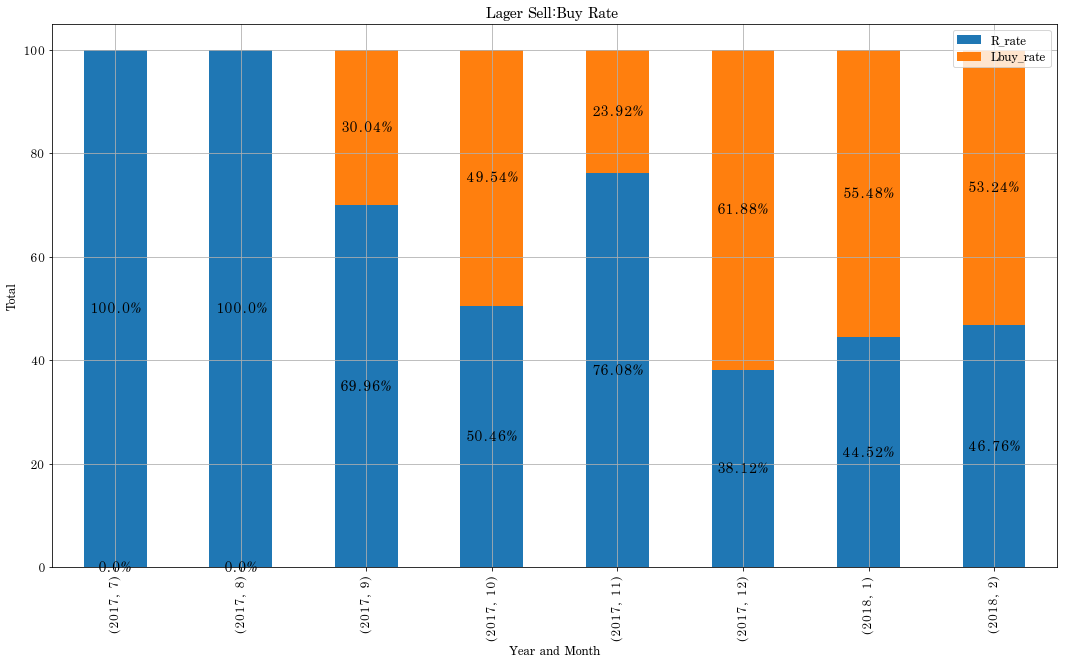

In [70]:

#plt.figure()

ax = DF_LM[['R_rate', 'Lbuy_rate']].plot.bar(stacked=True, figsize=(18,10), grid=True)

ax.set_title('Lager Sell:Buy Rate ')
ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

labels = []
for j in DF_LM[['R_rate', 'Lbuy_rate']].columns:
    pct_str=""
    for i in DF_LM.index:
#        value_str = "{:<12,}".format(int(DF_LM.loc[i][j])) 
        value_str = "{0:.4}%".format(DF_LM.loc[i][j]) 
        
        labels.append(value_str)

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize = 14)


fig = ax.get_figure()
fig.savefig('2-8-Lager Sell-Buy Rate.png')
plt.show()



## 2-9-Ale

In [71]:
sql_ale_sales = """
                select year, month, sum(amount) as Asales
                from sales
                where cat2 = 22 or cat2 = 62
                group by year, month
"""
DF_Asales = pd.read_sql_query(sql_ale_sales, conn_sales)
DF_Asales = DF_Asales.set_index(['year', 'month'])

sql_ale_buy = """
                select year, month, sum(amount) as Abuy
                from beer
                where cat = 22
                group by year, month
"""
DF_Abuy = pd.read_sql_query(sql_ale_buy, conn_sales)
DF_Abuy = DF_Abuy.set_index(['year', 'month'])

DF_AM = pd.concat([DF_Asales, DF_Abuy], axis=1)
DF_AM.loc[DF_AM['Abuy'].isnull(), 'Abuy']= 0
DF_AM['Abuy_rate'] = DF_AM['Abuy'] / DF_AM['Asales'] * 100
DF_AM['R_rate'] = 100 - DF_AM['Abuy_rate']
DF_AM

Asales       Abuy  Abuy_rate      R_rate
year month                                            
2017 7      21883523        0.0   0.000000  100.000000
     8      21403900        0.0   0.000000  100.000000
     9      16190550  5431800.0  33.549200   66.450800
     10     12566800  2911000.0  23.164210   76.835790
     11     10270300  1869000.0  18.198105   81.801895
     12     10571555  2380000.0  22.513244   77.486756
2018 1      11985900  1939000.0  16.177342   83.822658
     2       9440026  2142500.0  22.695912   77.304088

### Ale Sell:Buy Graph

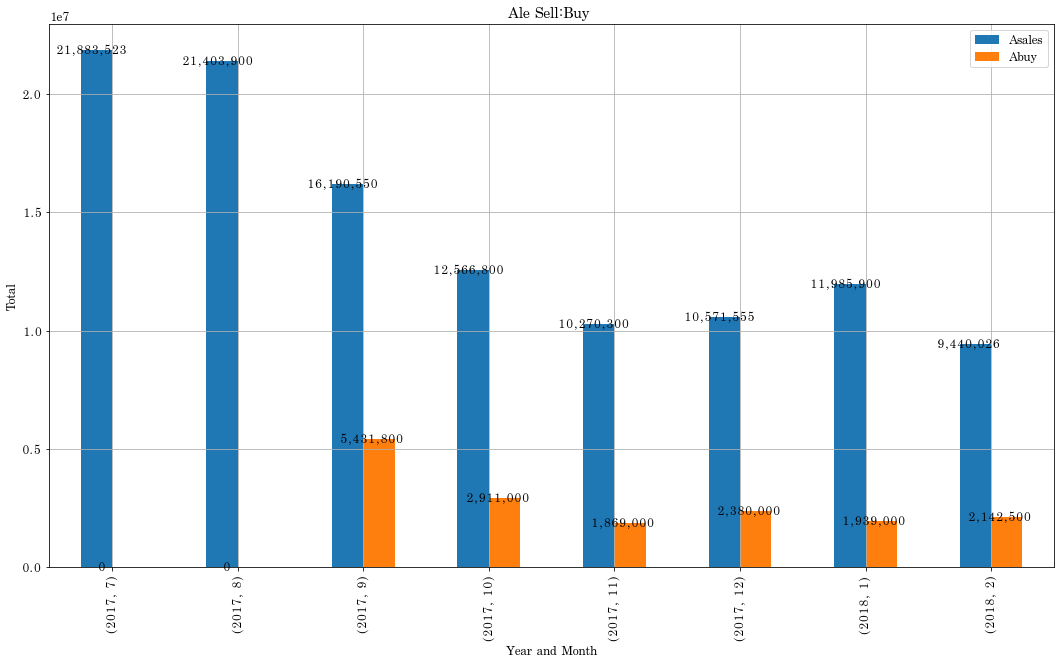

In [72]:

#plt.figure()

ax = DF_AM[['Asales', 'Abuy']].plot.bar(stacked=False, figsize=(18,10), grid=True)

ax.set_title('Ale Sell:Buy ')
ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

labels = []
for j in DF_AM[['Asales', 'Abuy']].columns:
    pct_str=""
    for i in DF_AM.index:
        value_str = "{:<12,}".format(int(DF_AM.loc[i][j])) 
        
        labels.append(value_str)

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height+0.5, label, ha='center', va='center', fontsize = 12)


fig = ax.get_figure()
fig.savefig('2-9-Ale Sell-Buy.png')
plt.show()



## 2-10-Ale Sell:Buy Rate

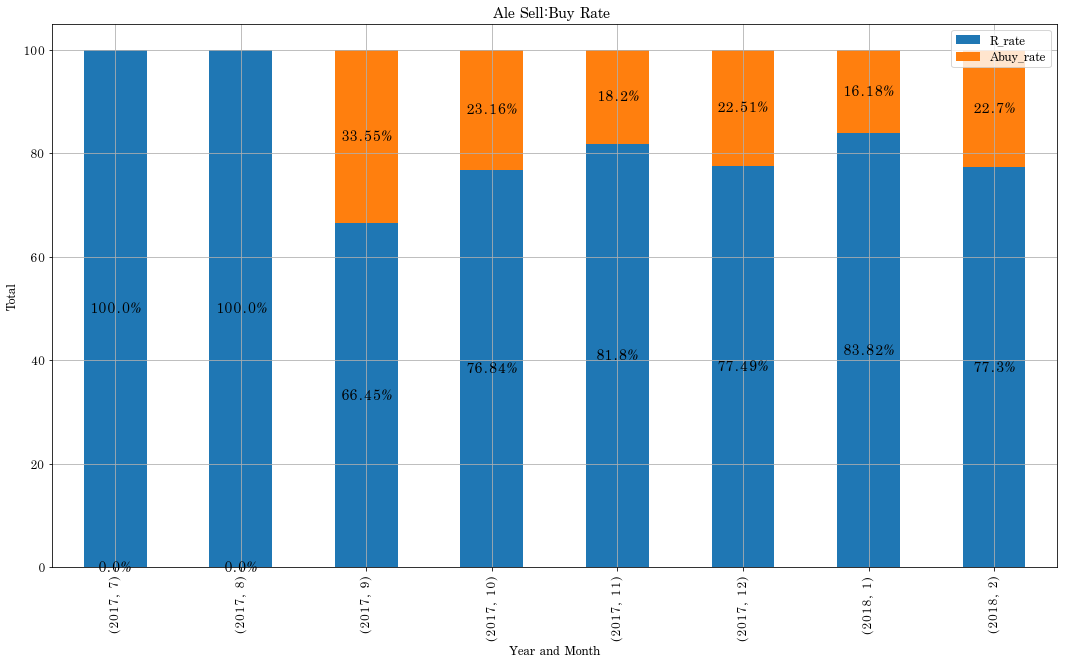

In [73]:

#plt.figure()

ax = DF_AM[['R_rate', 'Abuy_rate']].plot.bar(stacked=True, figsize=(18,10), grid=True)

ax.set_title('Ale Sell:Buy Rate ')
ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

labels = []
for j in DF_AM[['R_rate', 'Abuy_rate']].columns:
    value_str=""
    for i in DF_AM.index:
#        value_str = "{:<12,}".format(int(DF_LM.loc[i][j])) 
        value_str = "{0:.4}%".format(DF_AM.loc[i][j]) 
        
        labels.append(value_str)

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize = 14)


fig = ax.get_figure()
fig.savefig('2-10-Ale Sell-Buy Rate.png')
plt.show()
    




## 2-11- Angry

In [74]:
sql_angry_sales = """
                select year, month, sum(amount) as Angry_sales
                from sales
                where cat2 = 35
                group by year, month
"""
DF_Angry_sales = pd.read_sql_query(sql_angry_sales, conn_sales)
DF_Angry_sales = DF_Angry_sales.set_index(['year', 'month'])

sql_angry_buy = """
                select year, month, sum(total) as Angry_buy
                from OrderAll
                where sku = '424782'
                group by year, month
"""
DF_Angry_buy = pd.read_sql_query(sql_angry_buy, conn_sales)
DF_Angry_buy = DF_Angry_buy.set_index(['year', 'month'])

DF_Angry_M = pd.concat([DF_Angry_sales, DF_Angry_buy], axis=1)
DF_Angry_M.loc[DF_Angry_M['Angry_buy'].isnull(), 'Angry_buy']= 0
DF_Angry_M['Angry_buy_rate'] = DF_Angry_M['Angry_buy'] / DF_Angry_M['Angry_sales'] * 100
DF_Angry_M['R_rate'] = 100 - DF_Angry_M['Angry_buy_rate']
DF_Angry_M

Angry_sales  Angry_buy  Angry_buy_rate     R_rate
year month                                                   
2017 7          4344269    1672440       38.497616  61.502384
     8          4456000    1552980       34.851436  65.148564
     9          2208000    1254330       56.808424  43.191576
     10         2906000    1015410       34.941844  65.058156
     11         2159750     657030       30.421577  69.578423
     12         2115600     836220       39.526375  60.473625
2018 1          2285000     597300       26.140044  73.859956
     2          2012517     597300       29.679252  70.320748

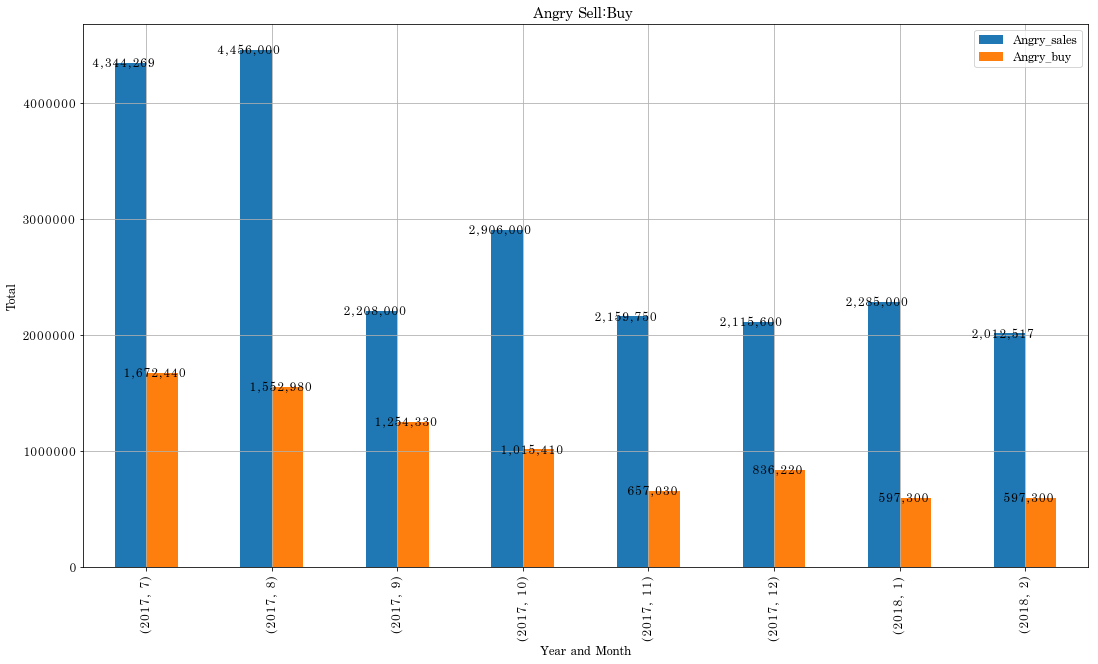

In [75]:

#plt.figure()

ax = DF_Angry_M[['Angry_sales', 'Angry_buy']].plot.bar(stacked=False, figsize=(18,10), grid=True)

ax.set_title('Angry Sell:Buy ')
ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

labels = []
for j in DF_Angry_M[['Angry_sales', 'Angry_buy']].columns:
    pct_str=""
    for i in DF_Angry_M.index:
        value_str = "{:<12,}".format(int(DF_Angry_M.loc[i][j])) 
        
        labels.append(value_str)

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height+0.5, label, ha='center', va='center', fontsize = 12)


fig = ax.get_figure()
fig.savefig('2-11-Angry Sell-Buy.png')
plt.show()




## 2-12-Angry(%)

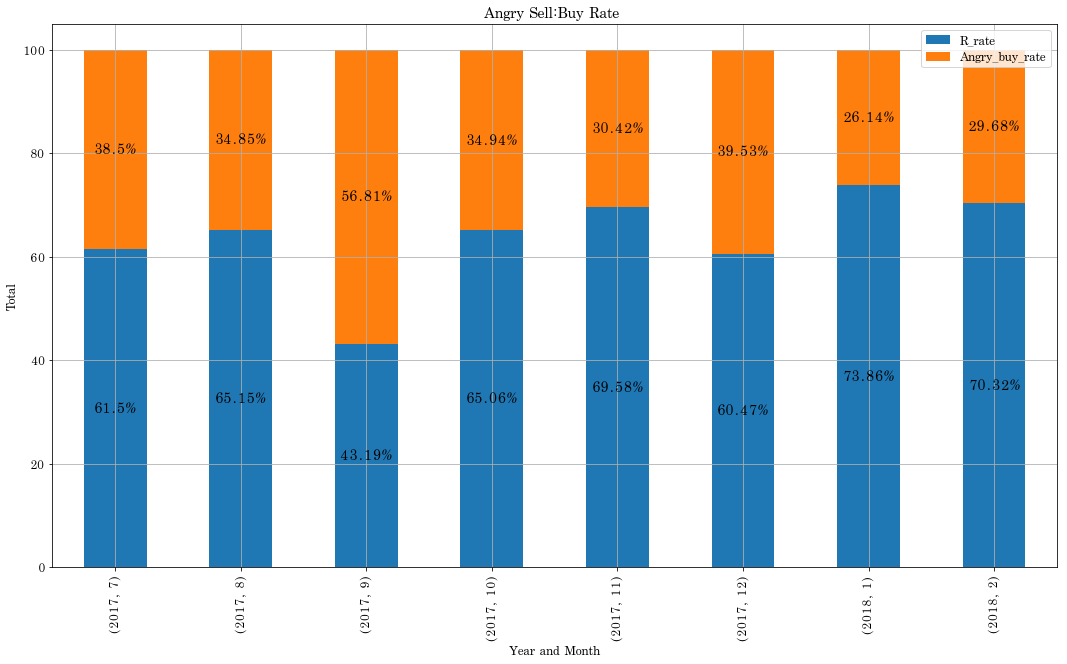

In [76]:

#plt.figure()

ax = DF_Angry_M[['R_rate', 'Angry_buy_rate']].plot.bar(stacked=True, figsize=(18,10), grid=True)

ax.set_title('Angry Sell:Buy Rate ')
ax.set_xlabel('Year and Month')
ax.set_ylabel('Total')

labels = []
for j in DF_Angry_M[['R_rate', 'Angry_buy_rate']].columns:
    value_str=""
    for i in DF_Angry_M.index:
#        value_str = "{:<12,}".format(int(DF_LM.loc[i][j])) 
        value_str = "{0:.4}%".format(DF_Angry_M.loc[i][j]) 
        
        labels.append(value_str)

patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
#        csv = "{:<12,}".format(int(label))
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize = 14)


fig = ax.get_figure()
fig.savefig('2-12-Angry Sell-Buy Rate.png')
plt.show()





# 99. Test Section